# Loading Data

In [13]:
from numbers import Number
from collections import defaultdict

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

import sina.datastores.sql as sina_sql
import sina.utils
from sina.datastore import create_datastore
from sina.visualization import Visualizer
from sina.model import Record, generate_record_from_json
import math
import statistics

%matplotlib notebook

# Initialization
database = '../04_manage_data/data/ensembles_output.sqlite'
target_type = "csv_rec"
datastore = create_datastore(database)
recs = datastore.records
vis = Visualizer(datastore)
print("Sina is ready!")



# Baseline Initialization
database_baseline = '../01_baseline_simulation/baseline/data/baseline_output.sqlite'
datastore_baseline = create_datastore(database_baseline)
recs_baseline = datastore_baseline.records

val = recs_baseline.get('47bcda_0')
print(val.data.keys()) # since there are no embedded keys we can just use this
#print(val.curve_sets) # no curve sets



x_true = val.data['x_pos']['value']
y_true = val.data['y_pos']['value']
z_true = val.data['z_pos']['value']
time_true = val.data['time']['value']


Sina is ready!
dict_keys(['x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial', 'gravity', 'box_side_length', 'group_id', 'time', 'x_pos', 'y_pos', 'z_pos', 'x_vel_final', 'y_vel_final', 'z_vel_final', 'num_bounces', 'x_rmse', 'x_diff', 'y_rmse', 'y_diff', 'z_rmse', 'z_diff'])


# Adding Data to Records

In [14]:
mean_rec = Record(id= "mean", type="summary")

x_temp = []
y_temp = []
z_temp = []

x_mean = []
y_mean = []
z_mean = []
x_std = []
y_std = []
z_std = []

for i , t in enumerate(time_true):

    for rec in recs.get_all():
        
        x_pred = rec.data['x_pos']['value'][i]
        y_pred = rec.data['y_pos']['value'][i]
        z_pred = rec.data['z_pos']['value'][i]

        x_temp.append(x_pred)
        y_temp.append(y_pred)
        z_temp.append(z_pred)
        
    x_mean.append(statistics.mean(x_temp))
    y_mean.append(statistics.mean(y_temp))
    z_mean.append(statistics.mean(z_temp))
    x_std.append(statistics.stdev(x_temp))
    y_std.append(statistics.stdev(y_temp))
    z_std.append(statistics.stdev(z_temp))
    
    x_temp = []
    y_temp = []
    z_temp = []

mean_rec.add_data('time',time)
mean_rec.add_data('x_pos_mean',x_mean)
mean_rec.add_data('y_pos_mean',y_mean)
mean_rec.add_data('z_pos_mean',z_mean)
mean_rec.add_data('x_pos_std',x_std)
mean_rec.add_data('y_pos_std',y_std)
mean_rec.add_data('z_pos_std',z_std)    

mean_rec.add_data('x_pos_mean_plus_std', [ x_mean[i] + x_std[i] for i in range (len (time))])
mean_rec.add_data('y_pos_mean_plus_std', [ y_mean[i] + y_std[i] for i in range (len (time))])
mean_rec.add_data('z_pos_mean_plus_std', [ z_mean[i] + z_std[i] for i in range (len (time))])
mean_rec.add_data('x_pos_mean_minus_std', [ x_mean[i] - x_std[i] for i in range (len (time))])
mean_rec.add_data('y_pos_mean_minus_std', [ y_mean[i] - y_std[i] for i in range (len (time))])
mean_rec.add_data('z_pos_mean_minus_std', [ z_mean[i] - z_std[i] for i in range (len (time))])

mean_rec.add_data('x_pos_mean_plus_2std', [ x_mean[i] + 2*x_std[i] for i in range (len (time))])
mean_rec.add_data('y_pos_mean_plus_2std', [ y_mean[i] + 2*y_std[i] for i in range (len (time))])
mean_rec.add_data('z_pos_mean_plus_2std', [ z_mean[i] + 2*z_std[i] for i in range (len (time))])
mean_rec.add_data('x_pos_mean_minus_2std', [ x_mean[i] - 2*x_std[i] for i in range (len (time))])
mean_rec.add_data('y_pos_mean_minus_2std', [ y_mean[i] - 2*y_std[i] for i in range (len (time))])
mean_rec.add_data('z_pos_mean_minus_2std', [ z_mean[i] - 2*z_std[i] for i in range (len (time))])

recs.insert(mean_rec) # need to update or else won't save!!!!!    
    

# Plotting QoIs and their Diff

<IPython.core.display.Javascript object>


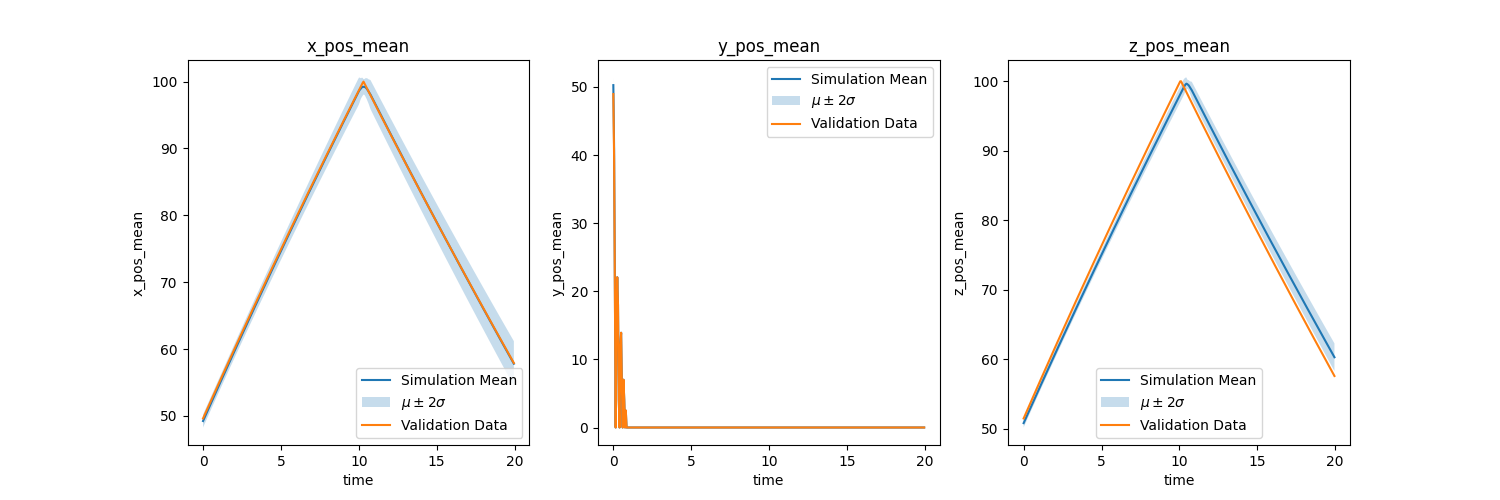

In [15]:
mean = recs.get('mean')
time = mean.data['time']['value']
x_pos_mean_plus_2std = mean.data['x_pos_mean_plus_2std']['value']
y_pos_mean_plus_2std = mean.data['y_pos_mean_plus_2std']['value']
z_pos_mean_plus_2std = mean.data['z_pos_mean_plus_2std']['value']

x_pos_mean_minus_2std = mean.data['x_pos_mean_minus_2std']['value']
y_pos_mean_minus_2std = mean.data['y_pos_mean_minus_2std']['value']
z_pos_mean_minus_2std = mean.data['z_pos_mean_minus_2std']['value']


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))



_ = vis.create_line_plot(fig=fig, ax=ax[0],x="time", y="x_pos_mean", title = "{y_name}", id_pool=['mean'])
_ = vis.create_line_plot(fig=fig, ax=ax[1],x="time", y="y_pos_mean", title = "{y_name}", id_pool=['mean'])
_ = vis.create_line_plot(fig=fig, ax=ax[2],x="time", y="z_pos_mean", title = "{y_name}", id_pool=['mean'])



ax[0].fill_between(time,x_pos_mean_plus_2std,x_pos_mean_minus_2std, alpha=0.25)
ax[1].fill_between(time,y_pos_mean_plus_2std,y_pos_mean_minus_2std, alpha=0.25)
ax[2].fill_between(time,z_pos_mean_plus_2std,z_pos_mean_minus_2std, alpha=0.25)

ax[0].plot(time_true, x_true)
ax[1].plot(time_true, y_true)
ax[2].plot(time_true, z_true)


ax[0].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
ax[1].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
ax[2].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
fig.savefig("./images/QoIs_u_input.png")